# Workbook 02: Baselines, Dataset Objects, and Graph Visualisation

This workbook builds on the preprocessing artifacts from Workbook 01 and implements:

- deterministic experiment setup,
- loading + indexing of the labelled subgraph universe,
- structural diagnostics + visualisation,
- efficient component-wise edge/node “packing” for fast sampling,
- a PyTorch Geometric dataset interface,
- split hygiene verification,
- a pooled-feature tabular baseline,
- a minimal subgraph-GNN baseline.

## Reproducibility contract and paths

In [1]:
import json
import random
from dataclasses import asdict, dataclass
from pathlib import Path

import numpy as np
import pandas as pd

RNG_SEED = 7
np.random.seed(RNG_SEED)
random.seed(RNG_SEED)

PROJECT_ROOT = Path.cwd()


DATA_DIR = PROJECT_ROOT / "DATA"   

PROCESSED_DIR = DATA_DIR / "processed"
PARQUET_DIR   = PROCESSED_DIR / "parquet"
ARTIFACTS_DIR = PROCESSED_DIR / "artifacts"
ARRAYS_DIR    = PROCESSED_DIR / "arrays"

RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

@dataclass
class RunConfig:
    rng_seed: int = RNG_SEED
    project_root: str = str(PROJECT_ROOT)
    data_dir: str = str(DATA_DIR)
    processed_dir: str = str(PROCESSED_DIR)
    notes: str = "Workbook 02: baselines + visualisation"

cfg = RunConfig()
(Path(RESULTS_DIR) / "run_config.json").write_text(json.dumps(asdict(cfg), indent=2))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("Wrote:", RESULTS_DIR / "run_config.json")

PROJECT_ROOT: D:\THESIS
DATA_DIR: D:\THESIS\DATA
PROCESSED_DIR: D:\THESIS\DATA\processed
Wrote: D:\THESIS\results\run_config.json


## 1. Load the minimal research state

In [2]:

NODE_ID_COL    = "clId"
NODES_COMP_COL = "ccId"

SRC_COL  = "clId1"
DST_COL  = "clId2"
TX_ID_COL = "txId"  

CC_COMP_COL  = "ccId"
CC_LABEL_COL = "ccLabel"

def require_columns(df: pd.DataFrame, cols: list[str], name: str):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name} missing columns {missing}. Available: {df.columns.tolist()}")


nodes_path = DATA_DIR / "nodes.csv"
edges_path = DATA_DIR / "edges.csv"
cc_path    = DATA_DIR / "connected_components.csv"


nodes_parq = PARQUET_DIR / "nodes.parquet"
edges_parq = PARQUET_DIR / "edges.parquet"
cc_parq    = PARQUET_DIR / "connected_components.parquet"

if nodes_parq.exists():
    nodes = pd.read_parquet(nodes_parq)
else:
    nodes = pd.read_csv(nodes_path, low_memory=False)
if edges_parq.exists():
    edges = pd.read_parquet(edges_parq)
else:
    edges = pd.read_csv(edges_path, low_memory=False)
if cc_parq.exists():
    cc = pd.read_parquet(cc_parq)
else:
    cc = pd.read_csv(cc_path, low_memory=False)

require_columns(nodes, [NODE_ID_COL, NODES_COMP_COL], "nodes")
require_columns(edges, [SRC_COL, DST_COL], "edges")
require_columns(cc,    [CC_COMP_COL, CC_LABEL_COL], "connected_components")

# Dtypes
nodes[NODE_ID_COL] = nodes[NODE_ID_COL].astype("int64")
nodes[NODES_COMP_COL] = nodes[NODES_COMP_COL].astype("int64")
edges[SRC_COL] = edges[SRC_COL].astype("int64")
edges[DST_COL] = edges[DST_COL].astype("int64")
cc[CC_COMP_COL] = cc[CC_COMP_COL].astype("int64")
cc[CC_LABEL_COL] = cc[CC_LABEL_COL].astype("string")

print("Loaded shapes:", {"nodes": nodes.shape, "edges": edges.shape, "cc": cc.shape})

# Load artifacts from Workbook 01
node_features_path = ARRAYS_DIR / "node_features.npy"
labels_path = ARTIFACTS_DIR / "subgraph_labels.json"
splits_path = ARTIFACTS_DIR / "splits.json"

if not node_features_path.exists():
    raise FileNotFoundError(f"Missing {node_features_path}. Run Workbook 01 feature step.")
if not labels_path.exists():
    raise FileNotFoundError(f"Missing {labels_path}. Run Workbook 01 label step.")
if not splits_path.exists():
    raise FileNotFoundError(f"Missing {splits_path}. Run Workbook 01 split step.")

X = np.load(node_features_path)
subgraph_labels = json.loads(labels_path.read_text())
splits = json.loads(splits_path.read_text())

print("X shape:", X.shape, "dtype:", X.dtype)
print("Split sizes:", {k: len(v) for k, v in splits.items() if k in ['train','val','test']})

subgraph_labels = {int(k): v for k, v in subgraph_labels.items()}

Loaded shapes: {'nodes': (444521, 2), 'edges': (367137, 3), 'cc': (121810, 2)}
X shape: (444521, 43) dtype: int8
Split sizes: {'train': 85267, 'val': 12181, 'test': 24362}


### Build indexing maps

In [3]:
from collections import defaultdict

clid_to_row = pd.Series(nodes.index.values, index=nodes[NODE_ID_COL]).to_dict()

cc_to_rows = defaultdict(list)
for row_idx, ccid in zip(nodes.index.values, nodes[NODES_COMP_COL].values):
    cc_to_rows[int(ccid)].append(int(row_idx))

cc_to_rows = {ccid: np.asarray(rows, dtype=np.int64) for ccid, rows in cc_to_rows.items()}

unique_ccids = np.array(sorted(cc_to_rows.keys()), dtype=np.int64)
print("Num components from nodes:", len(unique_ccids))
print("Example ccId:", int(unique_ccids[0]), "num_nodes:", cc_to_rows[int(unique_ccids[0])].shape[0])

Num components from nodes: 121810
Example ccId: 0 num_nodes: 296


## 2. Structural diagnostics + visualisation

,count,mean,std,min,50%,90%,95%,99%,max
n_nodes,121810.0,3.649298,3.240420,2.00000,3.000000,6.0,8.000000,14.0,296.0
n_edges,121810.0,3.014014,4.500519,1.00000,2.000000,6.0,8.000000,17.0,353.0
density_directed,121810.0,0.418965,0.392680,0.00347,0.500000,0.5,0.666667,1.5,40.0
avg_degree_proxy,121810.0,1.446415,0.972836,1.00000,1.333333,2.0,2.333333,4.0,84.0


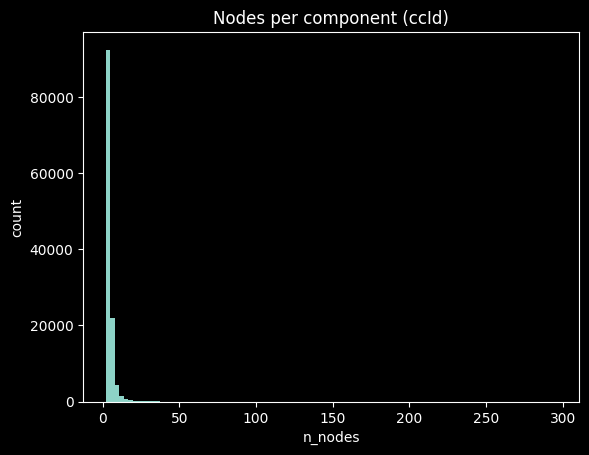

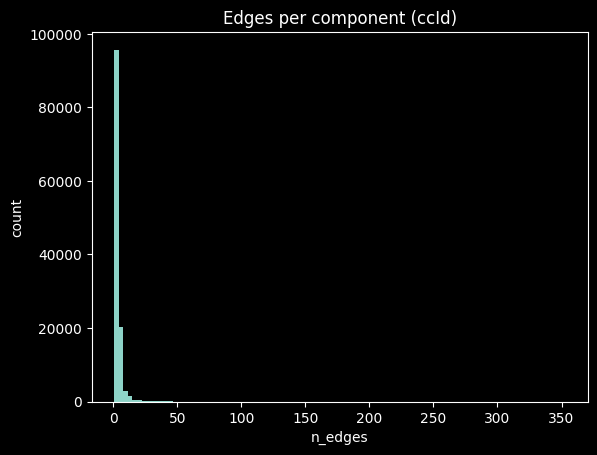

In [4]:
import matplotlib.pyplot as plt

nodes_per_cc = nodes.groupby(NODES_COMP_COL).size().rename("n_nodes")

cl_to_cc = pd.Series(nodes[NODES_COMP_COL].values, index=nodes[NODE_ID_COL].values)

edge_cc_src = edges[SRC_COL].map(cl_to_cc)
edge_cc_dst = edges[DST_COL].map(cl_to_cc)

same_cc_mask = edge_cc_src.notna() & edge_cc_dst.notna() & (edge_cc_src.values == edge_cc_dst.values)
edges_same = edges.loc[same_cc_mask, [SRC_COL, DST_COL]].copy()
edge_cc = edge_cc_src.loc[same_cc_mask].astype("int64")

edges_per_cc = edge_cc.value_counts().rename("n_edges")

stats = pd.DataFrame({"n_nodes": nodes_per_cc}).join(edges_per_cc, how="left").fillna({"n_edges": 0})
stats["n_edges"] = stats["n_edges"].astype("int64")

denom = stats["n_nodes"] * (stats["n_nodes"] - 1)
stats["density_directed"] = np.where(denom > 0, stats["n_edges"] / denom, 0.0)
stats["avg_degree_proxy"] = np.where(stats["n_nodes"] > 0, (2.0 * stats["n_edges"]) / stats["n_nodes"], 0.0)

display(stats.describe(percentiles=[.5,.9,.95,.99]).T)

plt.figure()
plt.hist(stats["n_nodes"].values, bins=100)
plt.title("Nodes per component (ccId)")
plt.xlabel("n_nodes")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(stats["n_edges"].values, bins=100)
plt.title("Edges per component (ccId)")
plt.xlabel("n_edges")
plt.ylabel("count")
plt.show()

### Visualise example components (small / medium / large)

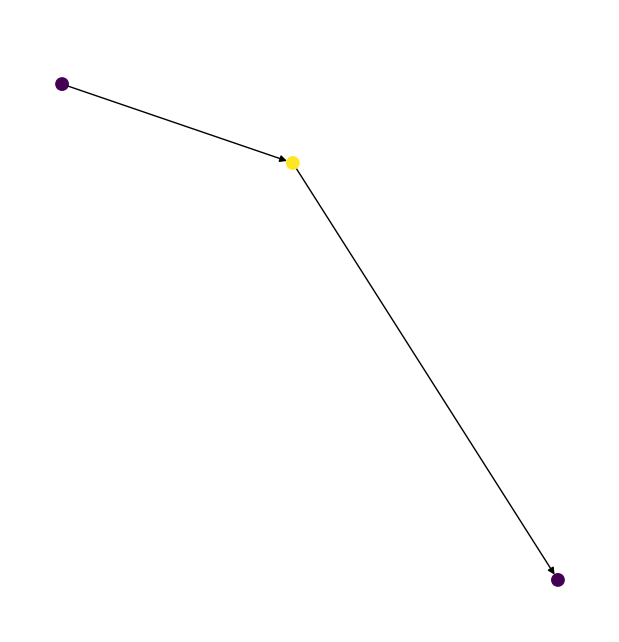

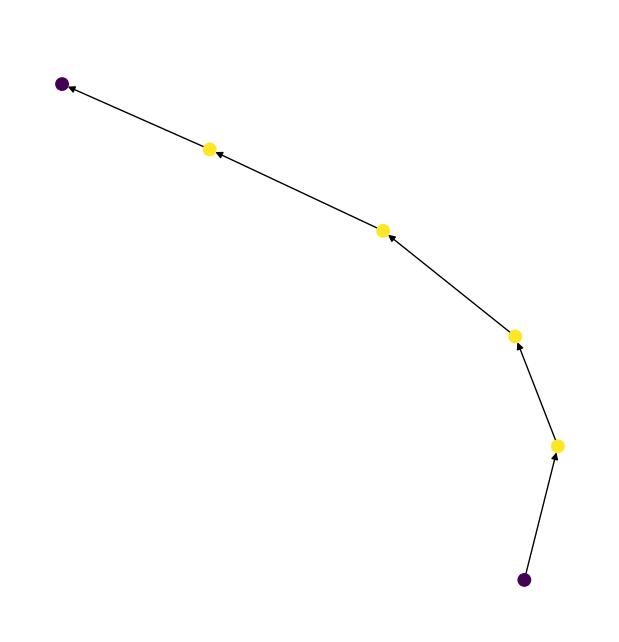

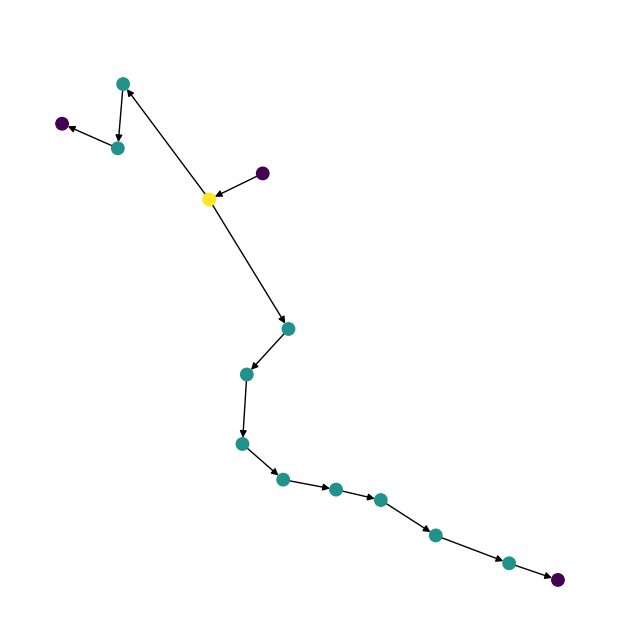

In [5]:
import networkx as nx

def pick_cc_by_percentile(p: float) -> int:
    target = stats["n_nodes"].quantile(p)
    return int((stats["n_nodes"] - target).abs().idxmin())

def build_component_graph(ccid: int, max_nodes: int | None = None) -> nx.DiGraph:
    node_rows = cc_to_rows[ccid]
    if max_nodes is not None and node_rows.shape[0] > max_nodes:
        node_rows = np.random.choice(node_rows, size=max_nodes, replace=False)
    clids = nodes.loc[node_rows, NODE_ID_COL].values
    clid_set = set(clids.tolist())

    e_mask = edges_same[SRC_COL].isin(clid_set) & edges_same[DST_COL].isin(clid_set)
    e = edges_same.loc[e_mask, [SRC_COL, DST_COL]].values

    G = nx.DiGraph()
    G.add_nodes_from(clids.tolist())
    G.add_edges_from((int(a), int(b)) for a, b in e)
    return G

def plot_graph(G: nx.DiGraph, title: str):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, seed=RNG_SEED)
    degrees = np.array([G.degree(n) for n in G.nodes()])
    nx.draw(G, pos, with_labels=False, node_size=80, node_color=degrees)
    plt.title(title)
    plt.show()

for p in [0.50, 0.90, 0.99]:
    ccid = pick_cc_by_percentile(p)
    G = build_component_graph(ccid, max_nodes=250)
    plot_graph(G, f"ccId={ccid} (≈{int(p*100)}th percentile), |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")

## 3. Pack nodes and edges by component

In [6]:
PACK_DIR = ARTIFACTS_DIR / "packed"
PACK_DIR.mkdir(exist_ok=True, parents=True)

# ---- Pack nodes ----
cc_ids_nodes = nodes[NODES_COMP_COL].astype(np.int64).values
node_row_indices = nodes.index.values.astype(np.int64)

order_nodes = np.argsort(cc_ids_nodes, kind="mergesort")
cc_ids_sorted_nodes = cc_ids_nodes[order_nodes]
node_row_perm = node_row_indices[order_nodes]

unique_cc, node_ptr = np.unique(cc_ids_sorted_nodes, return_index=True)
node_ptr = np.append(node_ptr, len(node_row_perm)).astype(np.int64)

# ---- Pack edges ----
src_row = edges_same[SRC_COL].map(clid_to_row).astype("int64").values
dst_row = edges_same[DST_COL].map(clid_to_row).astype("int64").values
edge_cc_arr = edge_cc.astype(np.int64).values

order_edges = np.argsort(edge_cc_arr, kind="mergesort")
edge_cc_sorted = edge_cc_arr[order_edges]
edge_src_row_perm = src_row[order_edges]
edge_dst_row_perm = dst_row[order_edges]

unique_cc_edges, edge_ptr = np.unique(edge_cc_sorted, return_index=True)
edge_ptr = np.append(edge_ptr, len(edge_cc_sorted)).astype(np.int64)

print("Packed components (nodes):", len(unique_cc))
print("Packed components (edges):", len(unique_cc_edges), "(components with ≥1 edge)")

np.savez_compressed(PACK_DIR / "nodes_by_ccid.npz", unique_cc=unique_cc, node_ptr=node_ptr, node_row_perm=node_row_perm)
np.savez_compressed(PACK_DIR / "edges_by_ccid.npz",
                    unique_cc_edges=unique_cc_edges, edge_ptr=edge_ptr,
                    edge_cc_sorted=edge_cc_sorted,
                    edge_src_row_perm=edge_src_row_perm, edge_dst_row_perm=edge_dst_row_perm)

print("Wrote:", PACK_DIR / "nodes_by_ccid.npz")
print("Wrote:", PACK_DIR / "edges_by_ccid.npz")

Packed components (nodes): 121810
Packed components (edges): 121810 (components with ≥1 edge)
Wrote: D:\THESIS\DATA\processed\artifacts\packed\nodes_by_ccid.npz
Wrote: D:\THESIS\DATA\processed\artifacts\packed\edges_by_ccid.npz


## 4. PyTorch Geometric dataset interface

In [8]:
import torch

try:
    from torch_geometric.data import Data
    from torch_geometric.loader import DataLoader as PyGDataLoader
    from torch_geometric.utils import to_undirected
    PYG_AVAILABLE = True
except Exception as e:
    PYG_AVAILABLE = False
    print("PyTorch Geometric not available:", repr(e))

nodes_pack = np.load(PACK_DIR / "nodes_by_ccid.npz")
edges_pack = np.load(PACK_DIR / "edges_by_ccid.npz")

unique_cc = nodes_pack["unique_cc"].astype(np.int64)
node_ptr = nodes_pack["node_ptr"].astype(np.int64)
node_row_perm = nodes_pack["node_row_perm"].astype(np.int64)

unique_cc_edges = edges_pack["unique_cc_edges"].astype(np.int64)
edge_ptr = edges_pack["edge_ptr"].astype(np.int64)
edge_src_row_perm = edges_pack["edge_src_row_perm"].astype(np.int64)
edge_dst_row_perm = edges_pack["edge_dst_row_perm"].astype(np.int64)

ccid_to_i = {int(ccid): i for i, ccid in enumerate(unique_cc)}
ccid_to_ei = {int(ccid): i for i, ccid in enumerate(unique_cc_edges)}

def label_to_int(lbl: str) -> int:
    lbl = str(lbl).lower()
    if lbl in {"suspicious", "illicit"}:
        return 1
    return 0

y_by_cc = {int(ccid): label_to_int(subgraph_labels[int(ccid)]) for ccid in unique_cc}

class Elliptic2SubgraphDataset(torch.utils.data.Dataset):
    def __init__(self, ccids: np.ndarray, make_undirected: bool = True):
        self.ccids = ccids.astype(np.int64)
        self.make_undirected = make_undirected

    def __len__(self):
        return self.ccids.shape[0]

    def __getitem__(self, idx: int):
        ccid = int(self.ccids[idx])
        i = ccid_to_i[ccid]
        rows = node_row_perm[node_ptr[i] : node_ptr[i+1]]
        x = torch.from_numpy(X[rows]).float()

        local = {int(r): j for j, r in enumerate(rows.tolist())}

        if ccid in ccid_to_ei:
            ei = ccid_to_ei[ccid]
            s = edge_src_row_perm[edge_ptr[ei] : edge_ptr[ei+1]]
            t = edge_dst_row_perm[edge_ptr[ei] : edge_ptr[ei+1]]
            src = torch.tensor([local[int(r)] for r in s], dtype=torch.long)
            dst = torch.tensor([local[int(r)] for r in t], dtype=torch.long)
            edge_index = torch.stack([src, dst], dim=0)
            if self.make_undirected and PYG_AVAILABLE:
                edge_index = to_undirected(edge_index)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)

        y = torch.tensor([y_by_cc[ccid]], dtype=torch.long)

        if not PYG_AVAILABLE:
            return {"ccId": ccid, "x": x, "edge_index": edge_index, "y": y}
        return Data(x=x, edge_index=edge_index, y=y, ccId=ccid)

ds = Elliptic2SubgraphDataset(unique_cc[:10])
s0 = ds[0]
print("PyG available:", PYG_AVAILABLE)
if PYG_AVAILABLE:
    print("Sample:", s0.x.shape, s0.edge_index.shape, s0.y.item(), "ccId", s0.ccId)
else:
    print("Sample:", s0["x"].shape, s0["edge_index"].shape, s0["y"].item(), "ccId", s0["ccId"])

PyG available: True
Sample: torch.Size([296, 43]) torch.Size([2, 604]) 0 ccId 0


## 5. Split hygiene verification

In [10]:
train_cc = np.array(splits["train"], dtype=np.int64)
val_cc   = np.array(splits["val"], dtype=np.int64)
test_cc  = np.array(splits["test"], dtype=np.int64)

def disjoint(a, b):
    return len(set(a.tolist()).intersection(set(b.tolist()))) == 0

assert disjoint(train_cc, val_cc)
assert disjoint(train_cc, test_cc)
assert disjoint(val_cc, test_cc)

all_cc = set(unique_cc.tolist())
for name, arr in [("train", train_cc), ("val", val_cc), ("test", test_cc)]:
    miss = [int(x) for x in arr.tolist() if int(x) not in all_cc]
    if miss:
        raise ValueError(f"{name} has missing ccIds (showing 10): {miss[:10]}")

def label_counts(arr):
    return pd.Series([subgraph_labels[int(x)] for x in arr.tolist()]).value_counts()

print(label_counts(train_cc).to_string())
print(label_counts(val_cc).to_string())
print(label_counts(test_cc).to_string())

licit         83333
suspicious     1934
licit         11905
suspicious      276
licit         23809
suspicious      553


## 6. Baseline A: pooled-feature tabular model (logistic regression)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve, confusion_matrix

def pooled_features(ccids: np.ndarray) -> np.ndarray:
    out = np.zeros((ccids.shape[0], X.shape[1] * 3), dtype=np.float32)
    for i, ccid in enumerate(ccids.tolist()):
        i_cc = ccid_to_i[int(ccid)]
        rows = node_row_perm[node_ptr[i_cc] : node_ptr[i_cc+1]]
        Xi = X[rows].astype(np.float32)
        out[i, 0:X.shape[1]] = Xi.mean(axis=0)
        out[i, X.shape[1]:2*X.shape[1]] = Xi.max(axis=0)
        out[i, 2*X.shape[1]:3*X.shape[1]] = Xi.std(axis=0)
    return out

def labels_for(ccids: np.ndarray) -> np.ndarray:
    return np.array([y_by_cc[int(c)] for c in ccids.tolist()], dtype=np.int64)

X_train = pooled_features(train_cc)
X_val   = pooled_features(val_cc)
X_test  = pooled_features(test_cc)

y_train = labels_for(train_cc)
y_val   = labels_for(val_cc)
y_test  = labels_for(test_cc)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

clf = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
clf.fit(X_train_s, y_train)

val_scores = clf.predict_proba(X_val_s)[:, 1]
test_scores = clf.predict_proba(X_test_s)[:, 1]

prec, rec, thr = precision_recall_curve(y_val, val_scores)
f1s = (2*prec*rec) / (prec+rec+1e-12)
best_i = int(np.nanargmax(f1s))
best_thr = float(thr[max(best_i-1, 0)]) if len(thr) else 0.5

test_pred = (test_scores >= best_thr).astype(int)

metrics = {
    "model": "logreg_pooled_mean_max_std",
    "val_roc_auc": float(roc_auc_score(y_val, val_scores)),
    "val_pr_auc": float(average_precision_score(y_val, val_scores)),
    "val_best_f1": float(np.nanmax(f1s)),
    "val_best_threshold": best_thr,
    "test_roc_auc": float(roc_auc_score(y_test, test_scores)),
    "test_pr_auc": float(average_precision_score(y_test, test_scores)),
    "test_f1_at_val_threshold": float(f1_score(y_test, test_pred)),
    "test_confusion_matrix": confusion_matrix(y_test, test_pred).tolist(),
}

(Path(RESULTS_DIR) / "baseline_tabular_metrics.json").write_text(json.dumps(metrics, indent=2))
print("Wrote:", RESULTS_DIR / "baseline_tabular_metrics.json")
metrics

C:\Users\neric\anaconda3\envs\tud-thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Wrote: D:\THESIS\results\baseline_tabular_metrics.json


{'model': 'logreg_pooled_mean_max_std',
 'val_roc_auc': 0.8754155786449488,
 'val_pr_auc': 0.14841969935085753,
 'val_best_f1': 0.24646983311892626,
 'val_best_threshold': 0.8651669206915854,
 'test_roc_auc': 0.8895014930834808,
 'test_pr_auc': 0.15393656176824935,
 'test_f1_at_val_threshold': 0.2510612492419648,
 'test_confusion_matrix': [[22920, 889], [346, 207]]}

### Visualisation: pooled-feature PCA (train sample)

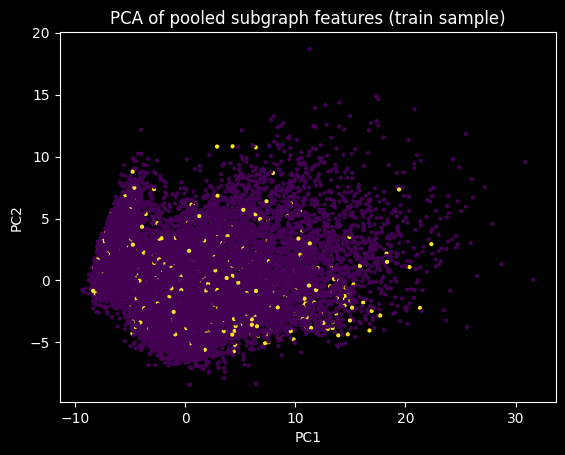

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_plot = min(20000, X_train_s.shape[0])
idx = np.random.choice(X_train_s.shape[0], size=n_plot, replace=False)

pca = PCA(n_components=2, random_state=RNG_SEED)
Z = pca.fit_transform(X_train_s[idx])

plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], s=4, c=y_train[idx])
plt.title("PCA of pooled subgraph features (train sample)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## 7. Baseline B: minimal GNN (GraphSAGE)

In [14]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve, confusion_matrix

if not PYG_AVAILABLE:
    raise RuntimeError("torch-geometric is required for Step 7. Install it and rerun.")

from torch_geometric.nn import SAGEConv, global_mean_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_ds = Elliptic2SubgraphDataset(train_cc, make_undirected=True)
val_ds   = Elliptic2SubgraphDataset(val_cc, make_undirected=True)
test_ds  = Elliptic2SubgraphDataset(test_cc, make_undirected=True)

train_loader = PyGDataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = PyGDataLoader(val_ds, batch_size=512, shuffle=False)
test_loader  = PyGDataLoader(test_ds, batch_size=512, shuffle=False)

class GraphSAGEClassifier(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 64):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.lin1 = nn.Linear(hidden, hidden)
        self.lin2 = nn.Linear(hidden, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        g = global_mean_pool(x, batch)
        g = F.relu(self.lin1(g))
        return self.lin2(g)

model = GraphSAGEClassifier(in_dim=X.shape[1], hidden=64).to(device)

train_labels = torch.tensor([y_by_cc[int(c)] for c in train_cc.tolist()], dtype=torch.long)
pos = int(train_labels.sum().item())
neg = int((train_labels == 0).sum().item())
class_weights = torch.tensor([1.0, (neg / max(pos, 1))], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def eval_loader(loader):
    model.eval()
    ys, scores = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            prob = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
            y = batch.y.detach().cpu().numpy().reshape(-1)
            ys.append(y)
            scores.append(prob)
    return np.concatenate(ys), np.concatenate(scores)

best_val_pr = -1.0
best_state = None
patience = 5
bad = 0

for epoch in range(1, 51):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optim.zero_grad()
        logits = model(batch)
        loss = criterion(logits, batch.y.view(-1))
        loss.backward()
        optim.step()
        total_loss += float(loss.item()) * batch.num_graphs

    yv, sv = eval_loader(val_loader)
    val_pr = float(average_precision_score(yv, sv))
    val_roc = float(roc_auc_score(yv, sv))
    print(f"epoch={epoch:03d} loss={total_loss/len(train_ds):.4f} val_pr={val_pr:.4f} val_roc={val_roc:.4f}")

    if val_pr > best_val_pr + 1e-4:
        best_val_pr = val_pr
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

yt, st = eval_loader(test_loader)

pv, rv, tv = precision_recall_curve(yv, sv)
f1v = (2*pv*rv) / (pv+rv+1e-12)
best_i = int(np.nanargmax(f1v))
best_thr = float(tv[max(best_i-1, 0)]) if len(tv) else 0.5

pred = (st >= best_thr).astype(int)

gnn_metrics = {
    "model": "graphsage_meanpool",
    "val_pr_auc_best": float(best_val_pr),
    "test_roc_auc": float(roc_auc_score(yt, st)),
    "test_pr_auc": float(average_precision_score(yt, st)),
    "test_f1_at_val_threshold": float(f1_score(yt, pred)),
    "val_best_threshold": best_thr,
    "test_confusion_matrix": confusion_matrix(yt, pred).tolist(),
}

(Path(RESULTS_DIR) / "baseline_gnn_metrics.json").write_text(json.dumps(gnn_metrics, indent=2))
print("Wrote:", RESULTS_DIR / "baseline_gnn_metrics.json")
gnn_metrics

Device: cuda
epoch=001 loss=0.6190 val_pr=0.1787 val_roc=0.8231
epoch=002 loss=0.5240 val_pr=0.2548 val_roc=0.8505
epoch=003 loss=0.4975 val_pr=0.2784 val_roc=0.8626
epoch=004 loss=0.4741 val_pr=0.2675 val_roc=0.8628
epoch=005 loss=0.4635 val_pr=0.2800 val_roc=0.8820
epoch=006 loss=0.4480 val_pr=0.3293 val_roc=0.8904
epoch=007 loss=0.4385 val_pr=0.3288 val_roc=0.8942
epoch=008 loss=0.4286 val_pr=0.3494 val_roc=0.8959
epoch=009 loss=0.4199 val_pr=0.3669 val_roc=0.8975
epoch=010 loss=0.4092 val_pr=0.2834 val_roc=0.8927
epoch=011 loss=0.4006 val_pr=0.3808 val_roc=0.9085
epoch=012 loss=0.3952 val_pr=0.3812 val_roc=0.9127
epoch=013 loss=0.3970 val_pr=0.3917 val_roc=0.9115
epoch=014 loss=0.3840 val_pr=0.4014 val_roc=0.9130
epoch=015 loss=0.3820 val_pr=0.3934 val_roc=0.9069
epoch=016 loss=0.3743 val_pr=0.4279 val_roc=0.9205
epoch=017 loss=0.3734 val_pr=0.4316 val_roc=0.9168
epoch=018 loss=0.3708 val_pr=0.4140 val_roc=0.9112
epoch=019 loss=0.3641 val_pr=0.3977 val_roc=0.9130
epoch=020 loss=0.3

{'model': 'graphsage_meanpool',
 'val_pr_auc_best': 0.44316678804929555,
 'test_roc_auc': 0.9136987342835466,
 'test_pr_auc': 0.40115606033173257,
 'test_f1_at_val_threshold': 0.41373671300081766,
 'val_best_threshold': 0.902656614780426,
 'test_confusion_matrix': [[23392, 417], [300, 253]]}

### Qualitative check: predicted vs true examples (test)

In [15]:
df_pred = pd.DataFrame({
    "ccId": test_cc.astype(int),
    "y_true": yt.astype(int),
    "y_score": st.astype(float),
    "y_pred": pred.astype(int),
}).sort_values("y_score", ascending=False)

display(df_pred.head(20))
display(df_pred.tail(20))

print("Positive rate (true):", float(df_pred["y_true"].mean()))
print("Positive rate (pred):", float(df_pred["y_pred"].mean()))

,ccId,y_true,y_score,y_pred
16802,72877,1,0.999855,1
9406,92169,1,0.999824,1
18099,37320,1,0.999784,1
103,109734,1,0.999775,1
729,100518,0,0.999771,1
10862,119426,1,0.999728,1
2991,111657,1,0.999664,1
21213,93283,1,0.999663,1
24037,75474,0,0.999653,1
744,79802,1,0.999651,1


,ccId,y_true,y_score,y_pred
22738,62679,0,1.195147e-10,0
24104,44893,0,9.152051e-11,0
23870,57915,0,7.720968e-11,0
5157,112202,0,7.279705e-11,0
13651,39180,0,6.179997e-11,0
16683,46002,0,5.887756e-11,0
280,47160,0,5.793446e-11,0
16724,45207,0,1.878333e-11,0
9837,32901,0,1.490937e-11,0
22063,62025,0,1.209889e-11,0


Positive rate (true): 0.022699285772925046
Positive rate (pred): 0.027501847138986946
